# Language Modeling

_Attention is all you need_ - Vaswani et al

**Transformers**, built on the **attention** mechanism, are neural network models designed to process variable-length sequences and capture complex dependencies in language without relying on recurrence or convolution. By leveraging self-attention, multi-head attention, and positional encodings, transformers can model long-range relationships between words for tasks like text generation, translation, and summarization. We apply transformer-based models to language modeling of Federal Reserve meeting minutes, introducing perplexity as a key evaluation metric and exploring decoding strategies such as nucleus sampling to generate coherent and diverse text.

In [54]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
from typing import Callable, List
import math
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import bisect
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize as tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torchinfo
from tqdm import tqdm
from finds.database.mongodb import MongoDB
from finds.unstructured import Unstructured, Vocab
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [55]:
mongodb = MongoDB(**credentials['mongodb'], verbose=VERBOSE)
fomc = Unstructured(mongodb, 'FOMC')
outdir = paths['scratch']
device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## Transformers

Transformers are a neural network architecture built entirely on attention mechanisms, designed to process variable-length sequential data without relying on recurrence (as in RNNs) or convolution (as in CNNs). They are especially effective for natural language processing (NLP) tasks such as language modeling, translation, and text generation.  

Traditional models like RNNs and CNNs face limitations when processing language data. RNNs are sequential, making them slow to train and difficult to parallelize, and they suffer from vanishing gradients. CNNs, while powerful for structured patterns like images, are less suited for variable-length, syntactically complex language sequences.  

Because language involves variable lengths, hierarchical syntax, and long-range dependencies, attention allows the model to focus on relevant parts of the input when generating outputs. To introduce positional information, since Transformers lack an inherent sense of sequential order, positional encodings to provide information about work positions are added to the token embeddings. In autoregressive tasks, **causal masks** are applied to ensure that each token only attends to previous tokens, not future ones.



### Attention mechanism


Attention is a mechanism that enables models to reason about a **set of elements and their relationships**, dynamically weighting the importance of different parts of the input. 

Attention is essentially a set operator designed to reason about a set of elements and their relationships, dynamically weighting the importance of different parts of the input when producing each element of the output sequence.  Unlike RNNs, attention does not require sequential processing, making it highly parallelizable and efficient for sequence modeling.  

The inputs to the attention operator are called:
- Queries (Q): What we're looking for.
- Keys (K): Labels that help identify relevant content.
- Values (V): The actual content or information to aggregate.

In **self-attention**, these inputs are all derived from the same input, allowing each input element to attend to every other element. Each input token is represented by three vectors: _query_, _key_, and _value_. Attention scores are computed as a scaled dot product between queries and keys, and these scores weight the values to produce a contextualized representation:

$$
\text{Attention}(Q, K, V) = \text{Softmax}\left( \frac{QK^\top}{\sqrt{C}} \right) V
$$

Learnable weight matrices $W_Q, W_K, W_V$ enable queries, keys, and values, respectively, to adapt to different input patterns:

$$
\text{Attention}(X; W_Q, W_K, W_V) = \text{Attention}(X W_Q, X W_K, X W_V)
$$

where $X$ is the embedded input.

**Cross-attention** is a mechanism used in encoder-decoder transformer architectures for tasks such as machine translation, where queries (Q) come from one source (typically the decoder) and keys (K) and values (V) come from another source (typically the encoder output)..

**Multi-head attention** runs multiple independent attention layers (heads) in parallel.
Each head learns different ways of attending to the input, capturing different aspects of the relationships.
Heads are concatenated and linearly projected back to the output dimension.



### Masked attention

Auto-regressive prediction is used for sequence generation tasks such as text completion and translation. To  ensure predictions are causal (based only on past and current information), causal masks hide future tokens when computing attention, The mask is just a upper-triangular matrix applied to the attention scores to block future tokens, ensuring that each word can only attend to itself and earlier words. This prevents the model from "cheating" by looking at future tokens when generating or predicting a sequence, preserving the causal structure required for tasks like language modeling and text completion.



### Positional encoding

Since Transformers treat inputs as sets of tokens without inherent order, **positional encodings** provide sequence information. These are added to token embeddings to enable the model to understand word positions.  
Types of positional encodings include:

- Absolute Positional Embeddings: Add a fixed position index to each input token.  Although simple and straightforward, this method is not generalizable to longer sequences than seen during training.

- Relative Positional Embeddings: encode pairwise distances between tokens. These relative distances are bounded and reusable, hence independent of the total length of the sequence.

- Sinusoidal Positional Embeddings: Predefined using sine and cosine functions of different frequencies. This can capture relative position information which generalizes to sequences longer than trained on.
$$
\text{PE}(n, 2i) = \sin\left(\frac{n}{10000^{2i/C}}\right), \quad \text{PE}(n, 2i+1) = \cos\left(\frac{n}{10000^{2i/C}}\right)
$$

- Rotary Positional Embeddings (RoPE): Combines both absolute and relative positional information through a rotation operation, which extrapolates well to longer contexts and is widely adopted in large language models (LLMs).

- Learnable Positional Embeddings: Initialized randomly and learned during training like token embeddings. This fully flexible, but performance may degrade if sequence length varies significantly between training and testing.





In [56]:
class PositionalEncoding(nn.Module):
    """Positional encoder, learned with an embeddings layer"""
    def __init__(self, d_model: int, max_len: int, dropout: float= 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.emb = nn.Embedding(num_embeddings=max_len, embedding_dim=d_model)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        to_embed = torch.LongTensor(np.asarray(range(0, x.size(1))))\
                        .to(x.device)
        embedded = self.emb(to_embed)
        embedded = self.dropout(embedded)
        return x + embedded.unsqueeze(0)
    
    """ Alternate positional encodings with sine function
    def __init__(self, d_model: int, max_len: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe[:, None, :] 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), 0, :]
        return self.dropout(x)
    """

### Transformer layers

A transformer-based neural network is built from repeated blocks of Transformer **layers**, each consisting of:

- Multi-Head Attention: Combines several attention "heads" that learn different relationships between tokens. Each head performs:
    $$
    \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{C}} \right)V
    $$
  and the final output is concatenated and linearly projected back to match input dimensions.

- Feedforward Neural Network: Applies a two-layer fully connected network (MLP) with non-linearity (typically ReLU) in between:
    $$
    \text{MLP}(x) = \text{ReLU}(\text{Linear}_1(x)) \rightarrow \text{Linear}_2
    $$

- Residual Connections: Directly connect input and output of each sub-layer.

- Layer Normalization: Normalizes inputs within each layer.


The input sentence is split into parts (characters, words, or "tokens"). The model takes token embeddings with positional encodings, applies layers of attention and MLPs, and outputs contextualized representations of each token.



In [57]:
class Transformer(nn.Module):
    """Transformer neural network"""
    def __init__(self, seq_len: int, vocab_size: int, d_model: int, nhead: int,
                 num_layers: int, dim_feedforward: int, dropout: float):
        super().__init__()

        # model dimensions
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.d_model = d_model

        # define layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=d_model)
        self.positional = PositionalEncoding(max_len=seq_len,
                                             d_model=d_model,
                                             dropout=dropout)

        layer = nn.TransformerEncoderLayer(d_model=d_model,
                                           nhead=nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout,
                                           batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer=layer,
                                             num_layers=num_layers)
        self.decoder = nn.Linear(in_features=d_model,
                                 out_features=vocab_size)

        # initialize weights
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.decoder.weight.data.uniform_(-0.1, 0.1)
        self.decoder.bias.data.zero_()

    def causal_mask(self, sz: int, device: str = 'cpu'):
        """returns upper triu set to -inf"""
        return nn.Transformer.generate_square_subsequent_mask(sz=self.seq_len,
                                                              device=device)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x[None, :]
        assert x.size(-1) == self.seq_len
        x = self.embedding(x) * math.sqrt(self.d_model)  # embedding
        x = self.positional(x)                           # position encoding
        x = self.encoder(x, mask=self.causal_mask(sz=len(x), device=x.device))
        x = self.decoder(x)                              # linear layer
        x = F.log_softmax(x, dim=-1)                     # classify
        return x

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

## Language modeling

**Language modeling** is the task of estimating the probability distribution over word sequences. By learning this distribution from large text corpora, models capture linguistic structure, enabling downstream tasks like translation and text generation.


### Perplexity

Accuracy (measuring whether the predicted word is exactly correct) is not a meaningful metric for language models.
Predicting the exact next word in a sequence is highly uncertain and difficult, so accuracy would be very low even for strong models. Instead, we care about how well the language model assigns probability distributions over possible next words. Perplexity quantifies how well the it predicts the test set, calculated as the exponential of the average negative log likelihood over the test set:

$$\text{Perplexity} = \exp\left( -\frac{1}{N} \sum_{i=1}^{N} \log P(w_i | w_{i-1}, \ldots, w_{i-n+1}) \right)$$

- $N$ is the total number of words in the test set.
- $P(w_i | w_{i-1}, \ldots, w_{i-n+1})$ is the probability assigned by the language model to the word $w_i$ given its context $w_{i-1}, \ldots, w_{i-n+1}$.

Intuitively, perplexity measures how surprised the model is by the text.  It can be interpreted as the geometric mean of the inverse probabilities assigned by the model, hence lower perplexity indicates better model performance and generalization.

In [58]:
def get_next_log_probs(model, context: List[str], unk=UNK):
    """log P(word | context) where word ranges over the vocab"""
    # pad to length seq_len
    if len(context) > model.seq_len:
        context = context[-model.seq_len:]
    elif len(context) < model.seq_len:
        context = ([unk] * (model.seq_len - len(context))) + context
    context = torch.LongTensor(vocab.get_index(context))\
                   .to(device)\
                   .unsqueeze(0)
    output = model(context)
    logits = output[0, -1, :]
    return logits.cpu().detach().numpy()

In [59]:
def get_perplexity(model, sentence: List[str]) -> float:
    """Compute perpexlity score"""

    context = [UNK] + sentence
    log_probs = 0
    for i in range(len(context) - len(sentence), len(context)):
        log_probs += get_next_log_probs(model=model, context=context[:i])[vocab.get_index(context[i])]
    return np.exp(-log_probs / len(sentence))

### Fedspeak

The Fed has a jargon all of its own, with Alan Blinder coining the term *Fedspeak* to describe the "turgid dialect of English" used by Federal Reserve Board chairs. We explore language modeling of minutes text from all FOMC meetings since 1993. 

The text data are tokenized and converted into indices in a `Vocab` object. PyTorch `Dataset` and `DataLoader` tools simplify the processing of chunks and batches of the data. The most recent document is held-out from training to serve as the test set for perplexity evaluation.

In [60]:
# Retrieve and preprocess FOMC minutes text
dates = fomc['minutes'].distinct('date')       # check dates stored in MongoDB
docs = Series({doc['date']: [w.lower() for w in tokenize(doc['text'])]
               for doc in fomc.select('minutes')},
              name='minutes').sort_index()
UNK = " "
vocab = Vocab(set().union(*docs.tolist()), unk=UNK)
print(f"{len(vocab)=}, {len(docs)=}: {min(dates)}-{max(dates)}")

len(vocab)=8675, len(docs)=256: 19930203-20250129


In [61]:
# Pytorch Dataset and DataLoader
class FOMCDataset(Dataset):
    """Subclass of torch Dataset

    Notes:
      All subclasses should overwrite __getitem__(),
      supporting fetching a data sample for a given key. Subclasses
      could also optionally overwrite __len__(), which is expected to
      return the size of the dataset
    """
    def __init__(self, text: Series, seq_len: int, get_index: Callable[[str], int]):
        self.text = text
        self.seq_len = seq_len
        self.get_index = get_index
        self.counts = np.cumsum([len(s) // seq_len for s in text])

    def __len__(self):
        return self.counts[-1]

    def __getitem__(self, idx):
        assert 0 <= idx < len(self), "idx out of range"
        doc = bisect.bisect_right(self.counts, idx)

        start = (idx - (self.counts[doc-1] if doc > 0 else 0)) * self.seq_len
        end = start + self.seq_len
        chunk = self.text.iloc[doc][start:end]
        return (torch.LongTensor([0] + self.get_index(chunk[:-1])),
                torch.LongTensor(self.get_index(chunk)))

# length of input sequence
seq_len = 30

# split last document to be test set
test_len = 1
test_set = docs.iloc[-test_len:].tolist()
train_set = FOMCDataset(docs.iloc[:-test_len], seq_len, vocab.get_index)
dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
DataFrame({'docs': len(docs)-test_len, 'chunks': len(train_set)}, index=['Train'])

,docs,chunks
Train,255,54877


Create the model:

In [62]:
# Create the model
lr = 0.0001
step_size = 30
num_epochs = 100 #step_size * 1

In [63]:
d_model = 512 #512
nhead = 4 # 4
num_layers = 3 # 2
dim_feedforward = 2048 # 512 #1024
dropout = 0.3 # 0.3 # 0.2

In [40]:
model = Transformer(seq_len=seq_len,
                    vocab_size=len(vocab), 
                    d_model=d_model, 
                    nhead=nhead,
                    num_layers=num_layers,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout).to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
Transformer                                                       --
├─Embedding: 1-1                                                  4,441,600
├─PositionalEncoding: 1-2                                         --
│    └─Dropout: 2-1                                               --
│    └─Embedding: 2-2                                             15,360
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          3,152,384
│    │    └─TransformerEncoderLayer: 3-2                          3,152,384
│    │    └─TransformerEncoderLayer: 3-3                          3,152,384
├─Linear: 1-4                                                     4,450,275
Total params: 18,364,387
Trainable params: 18,364,387
Non-trainable params: 0

Train the model:

In [41]:
# Specify training parameters
criterion = nn.NLLLoss().to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

In [42]:
perplexity = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for train_ex, target_ex in dataloader:
        optimizer.zero_grad()
        train_ex, target_ex = train_ex.to(device), target_ex.to(device)
        output = model(train_ex)
        loss = criterion(output.view(-1, len(vocab)), target_ex.view(-1))
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    # Evaluate perplexity on test set
    model.eval()
    perplexity.append(np.mean([get_perplexity(model, s) for s in test_set]))
    losses.append(loss.item())
    if VERBOSE:
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Perplexity: {perplexity[-1]}")
model.save(outdir / f"transformer{nhead}_{dim_feedforward}.pt")

100%|██████████| 100/100 [1:03:53<00:00, 38.33s/it]


In [66]:
# save model checkpoint
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')  ## ignore the weights_only=True future warning
    model.load(outdir / f"transformer{nhead}_{dim_feedforward}.pt")

Evaluate the model:

Perplexity: 10.185370762878241   Loss: 2.0497496128082275


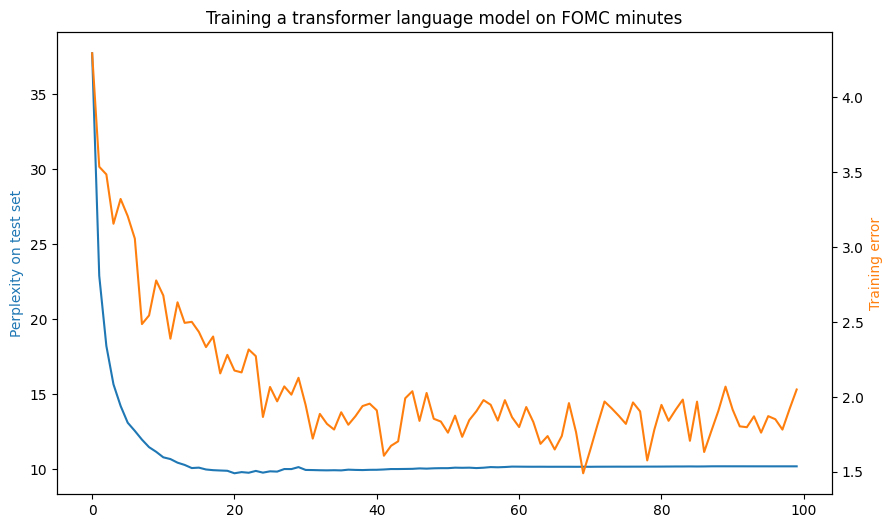

In [44]:
# Plot perplexity
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(perplexity, color="C0")
ax.set_ylabel('Perplexity on test set', color="C0")
bx = ax.twinx()
bx.plot(losses, color="C1")
bx.set_ylabel('Training error', color="C1")
plt.title('Training a transformer language model on FOMC minutes')
print('Perplexity:', perplexity[-1], '  Loss:', losses[-1])

### Decoding

Decoding refers to the process of generating a sequence of words based on learned probabilities. Language models generate text by sampling from a probability distribution over the next word $P(y_i | y_1, ..., y_{i-1})$, given previous words:

- __Greedy__ approach: At each step of generation, the word with the highest probability according to the model is selected as the next word. While simple and computationally efficient, this results in repetitive or less diverse outputs.

- __Beam search__ maintains a fixed number (beam width) of partial candidate sequences of words.At each step, it expands all possible next words for each candidate, keeping the top $k$ based on their joint probabilities. This allows exploration of multiple promising paths, but can be computationally expensive, and may still produce suboptimal outputs due to early pruning.

- __Nucleus Sampling__ samples from the smallest set of $k$ words whose cumulative probability mass exceeds a pre-defined threshold $p$. This approach promotes diversity in generated text by allowing for the possibility of sampling from a larger set of words. 


In [45]:
def get_nucleus_sequence(model, n: int, p: float, context: List[str] = []):
    """Sample sequence of words given context using nucleus sampling"""
    if not context:
        context = [UNK]
    
    for i in range(n):
        probs = np.exp(get_next_log_probs(model, context))
        probs_sorted = sorted(probs, reverse=True)
        probs_cum = np.cumsum(probs_sorted)
        num_drop = sum(probs_cum > p)
        threshold = probs_sorted[-num_drop]
        probs[probs < threshold] = 0.
        probs /= sum(probs)
        choice = vocab.get_word(np.random.choice(len(probs), p=probs))
        context.append(choice)
        #print(i, drop, len(probs), len(probs_sorted))
    return context

In [46]:
import textwrap
wrapper = textwrap.TextWrapper(width=80, fix_sentence_endings=True)

Finally, nucleus sampling with $p=0.95$ is used to generate new text conditioned on starting contexts, balancing diversity and coherence.

In [51]:
n, p = seq_len * 4, 0.95
for context in ['the financial markets' , 'participants noted that']:

    # generate from context with nuclear sampling
    words = get_nucleus_sequence(model, n=n, p=p, context=context.split())

    # pretty-print the output
    out = ''
    is_end = True
    is_space = ''
    for w in words:
        if not w.isalnum():
            out += w
        else:
            if is_end:
                w = w.capitalize()
            out += is_space + w
        is_end = w in ['!', '?', '.']
        is_space = ' '*bool(w not in ["'", '-', '–'])
    print(f"{context.upper()}...")
    print(wrapper.fill(out))
    print()

THE FINANCIAL MARKETS...
The financial markets.  In addition, the tga and the resulting decline in the
soma portfolio would result in a combination of shifts in the composition of
reserve liabilities, and a waning volume of credit allocation liquidity.  In
that regard, the appropriate course of monetary policy, a number of participants
noted that purchases of longer-term securities were faced by the likely onset of
the financial crisis in mid-december.  Labor market conditions improved further
in january but expanded modestly on balance over the intermeeting period.
Consumer price inflation— as measured by the 12-month percentage change in the
price index for personal consumption expenditures( pce)— was elevated in march

PARTICIPANTS NOTED THAT...
Participants noted that recent indicators and orders pointed to somewhat more
moderate expansion of spending for equipment and software.  The nominal deficit
on u.  S. Trade in goods and services was significantly larger in the third
quarter

**References:**

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

Jay Alammar, The Illustrated Transformer, retrieved from https://jalammar.github.io/illustrated-transformer/

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. Attention Is All You Need.  https://arxiv.org/abs/1706.03762

Greg Durrett, 2021-2024, "CS388 Natural Language Processing course materials", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html

Philipp Krähenbühl, 2020-2024, "AI394T Deep Learning course materials", retrieved from
https://www.philkr.net/dl_class/material and https://ut.philkr.net/deeplearning/